# Coursera Course Dataset Analysis

This analysis explores a Coursera dataset to uncover insights into course popularity, ratings, certificate types, and difficulty levels. Key objectives include understanding trends in student enrollment, identifying high-performing organizations, and analyzing the relationship between course features and student engagement.

Through data cleaning, exploratory data analysis (EDA), and visualization, the analysis aims to:

 - Highlight the most popular courses and organizations.
 - Examine the distribution of course difficulty, ratings, and certificate offerings.
 - Reveal correlations between enrollment, ratings, and course attributes.

The insights provide actionable recommendations for optimizing course design, improving student engagement, and aligning offerings with learner preferences.

In [67]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
print('Setup Complete')

Setup Complete


In [68]:
courses = pd.read_csv("Coursera_data.csv", index_col=[0])
courses[:3]

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k


In [94]:
courses.course_Certificate_type.unique()

array(['SPECIALIZATION', 'COURSE', 'PROFESSIONAL CERTIFICATE'],
      dtype=object)

# Data cleaning

In [69]:
courses.shape

(891, 6)

In [70]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 134 to 163
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_title              891 non-null    object 
 1   course_organization       891 non-null    object 
 2   course_Certificate_type   891 non-null    object 
 3   course_rating             891 non-null    float64
 4   course_difficulty         891 non-null    object 
 5   course_students_enrolled  891 non-null    object 
dtypes: float64(1), object(5)
memory usage: 48.7+ KB


In [71]:
courses.isnull().sum()

course_title                0
course_organization         0
course_Certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0
dtype: int64

In [72]:
courses.duplicated().any()

False

Checking duplicates in title

In [73]:
map = courses.duplicated("course_title", keep=False)
courses[map]

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
756,Developing Your Musicianship,Berklee College of Music,COURSE,4.8,Mixed,41k
205,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.8,Beginner,54k
181,Machine Learning,University of Washington,SPECIALIZATION,4.6,Intermediate,290k
6,Machine Learning,Stanford University,COURSE,4.9,Mixed,3.2m
241,Marketing Digital,Universidade de São Paulo,COURSE,4.8,Beginner,81k
325,Marketing Digital,Universidad Austral,SPECIALIZATION,4.7,Beginner,39k


No duplicates or Null values

In [74]:
# removing any possible excess spaces
courses = courses.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [75]:
# Changing 'course_students_enrolled' to numeric form
def convert_to_num(value):
    if isinstance(value, str):
        if "k" in value:
            return int(float(value.replace("k", "").replace(",", "")) * 1000)
        elif "m" in value:
            return int(float(value.replace("m", "").replace(",", "")) * 1000000)

    return int(value)


courses.course_students_enrolled = courses.course_students_enrolled.apply(
    convert_to_num
)
courses.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5300
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17000
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130000
413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91000
635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320000


Outliers

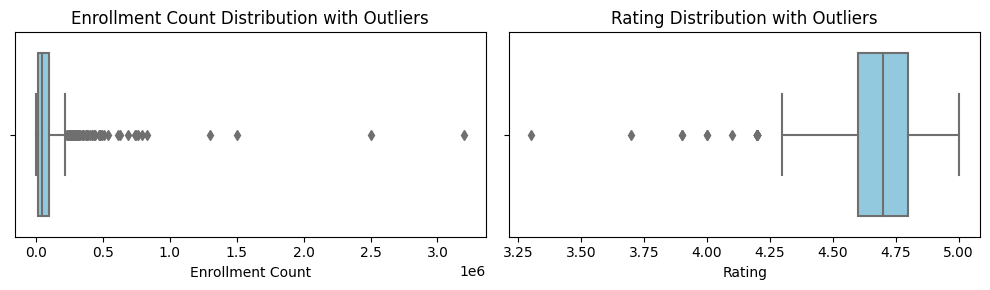

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot Enrollment Count Distribution with Outliers
sns.boxplot(x=courses.course_students_enrolled, color="skyblue", ax=axes[0])
axes[0].set_title("Enrollment Count Distribution with Outliers")
axes[0].set_xlabel("Enrollment Count")

# Plot Rating Distribution with Outliers
sns.boxplot(x=courses.course_rating, color="skyblue", ax=axes[1])
axes[1].set_title("Rating Distribution with Outliers")
axes[1].set_xlabel("Rating")

# Display the plots
plt.tight_layout()

- Very few outliers, no data issue.

Removing outliers for some general analysis in future

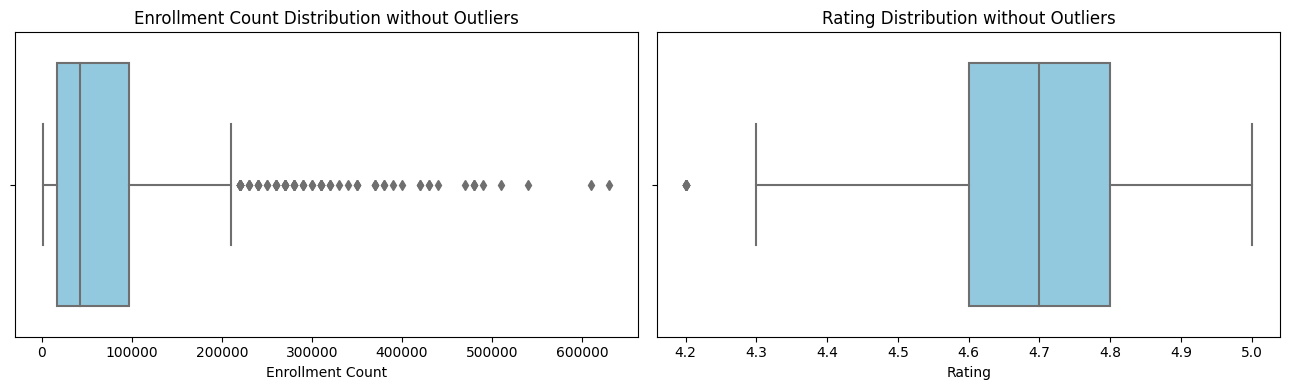

In [77]:
z_scores_enrolled = stats.zscore(courses.course_students_enrolled)
z_scores_rating = stats.zscore(courses.course_rating)
threshold = 3
# Filter out rows with Z-scores above the threshold
cleaned_courses_z = courses[
    (abs(z_scores_enrolled) < threshold) & (abs(z_scores_rating) < threshold)
]

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Plot Enrollment Count Distribution with Outliers
sns.boxplot(x=cleaned_courses_z.course_students_enrolled, color="skyblue", ax=axes[0])
axes[0].set_title("Enrollment Count Distribution without Outliers")
axes[0].set_xlabel("Enrollment Count")

# Plot Rating Distribution with Outliers
sns.boxplot(x=cleaned_courses_z.course_rating, color="skyblue", ax=axes[1])
axes[1].set_title("Rating Distribution without Outliers")
axes[1].set_xlabel("Rating")

# Display the plots
plt.tight_layout()

# EDA

### General Overview

In [78]:
courses.describe(include="all")

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
count,891,891,891,891.000000,891,8.910000e+02
unique,888,154,3,NaN,4,NaN
top,Developing Your Musicianship,University of Pennsylvania,COURSE,NaN,Beginner,NaN
freq,2,59,582,NaN,487,NaN
mean,NaN,NaN,NaN,4.677329,NaN,9.055208e+04
std,NaN,NaN,NaN,0.162225,NaN,1.819365e+05
min,NaN,NaN,NaN,3.300000,NaN,1.500000e+03
25%,NaN,NaN,NaN,4.600000,NaN,1.750000e+04
50%,NaN,NaN,NaN,4.700000,NaN,4.200000e+04
75%,NaN,NaN,NaN,4.800000,NaN,9.950000e+04


Categorical fields

In [79]:
list(courses.select_dtypes(include="object").columns)

['course_title',
 'course_organization',
 'course_Certificate_type',
 'course_difficulty']

Numeric fields

In [80]:
list(courses.select_dtypes(exclude="object").columns)

['course_rating', 'course_students_enrolled']

Number of organizations

In [81]:
courses.course_organization.value_counts().size

154

Text(0.5, 0, 'Difficulty Level')

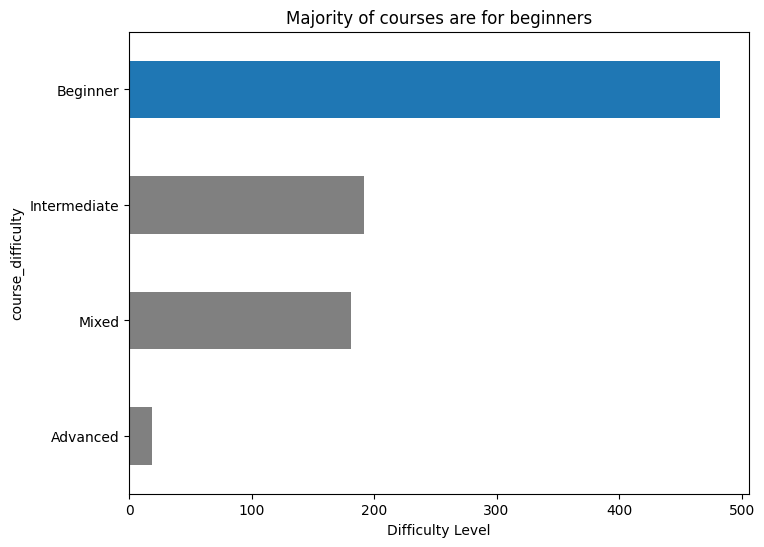

In [125]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = (
    cleaned_courses_z.groupby("course_difficulty")
    .size()
    .sort_values()
    .plot(kind="barh")
)
for i in range(len(ax.patches)):
    if i != 3:
        ax.patches[i].set_facecolor("grey")
plt.title("Majority of courses are for beginners")
plt.xlabel("Difficulty Level")

### Rating

Text(0.5, 0, 'Rating')

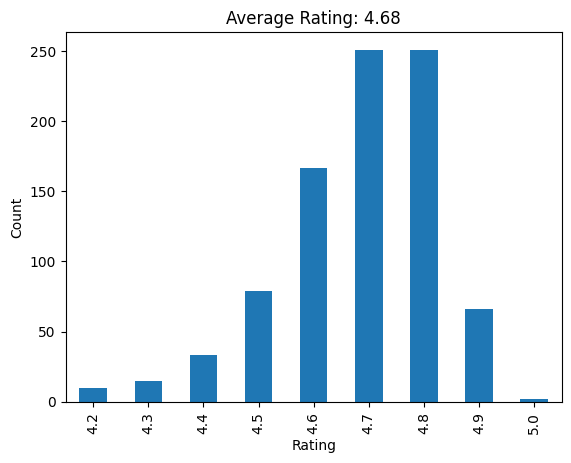

In [111]:
rating_counts = cleaned_courses_z["course_rating"].value_counts()
rating_counts.sort_index().plot(kind="bar")
plt.title(f"Average Rating: {cleaned_courses_z['course_rating'].mean():.2f}")
plt.ylabel("Count")
plt.xlabel("Rating")

- Most courses have high rating.

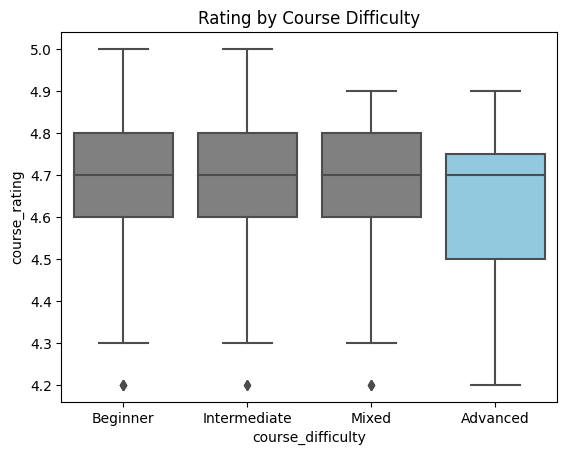

In [ ]:
palette = ["grey", "grey", "grey", "skyblue"]  # adjust colors

sns.boxplot(
    x="course_difficulty", y="course_rating", data=cleaned_courses_z, palette=palette
)
plt.title("Rating by Course Difficulty")
plt.show()

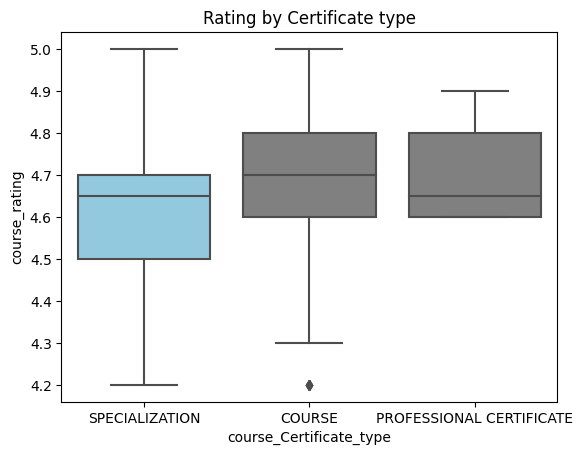

In [ ]:
palette = ["skyblue", "grey", "grey"]
sns.boxplot(
    x="course_Certificate_type",
    y="course_rating",
    data=cleaned_courses_z,
    palette=palette,
)
plt.title("Rating by Certificate type")
plt.show()

### Enrolled count

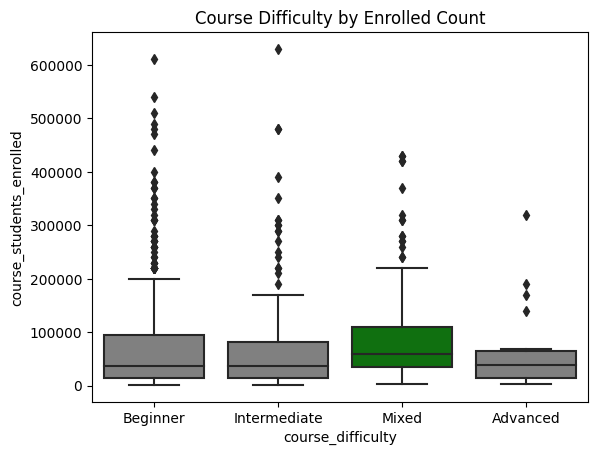

In [ ]:
palette = [
    "grey",
    "grey",
    "green",
    "grey",
]
sns.boxplot(
    x="course_difficulty",
    y="course_students_enrolled",
    data=cleaned_courses_z,
    palette=palette,
)
plt.title("Course Difficulty by Enrolled Count")
plt.show()

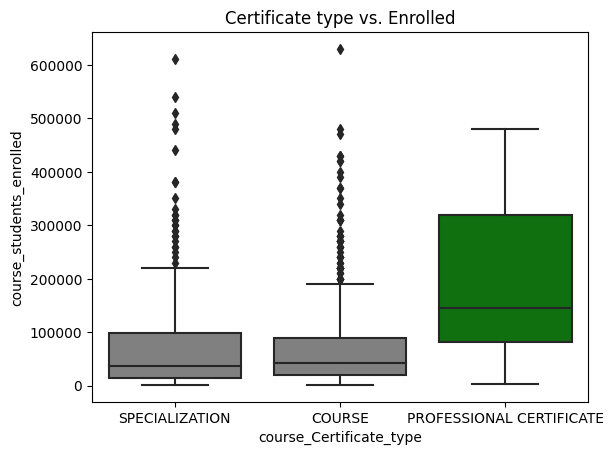

In [ ]:
palette = ["grey", "grey", "green"]
sns.boxplot(
    x="course_Certificate_type",
    y="course_students_enrolled",
    data=cleaned_courses_z,
    palette=palette,
)
plt.title("Certificate type by Enrolled Count")
plt.show()

- The most popular type is the Professional Certificate

### Top 20 courses

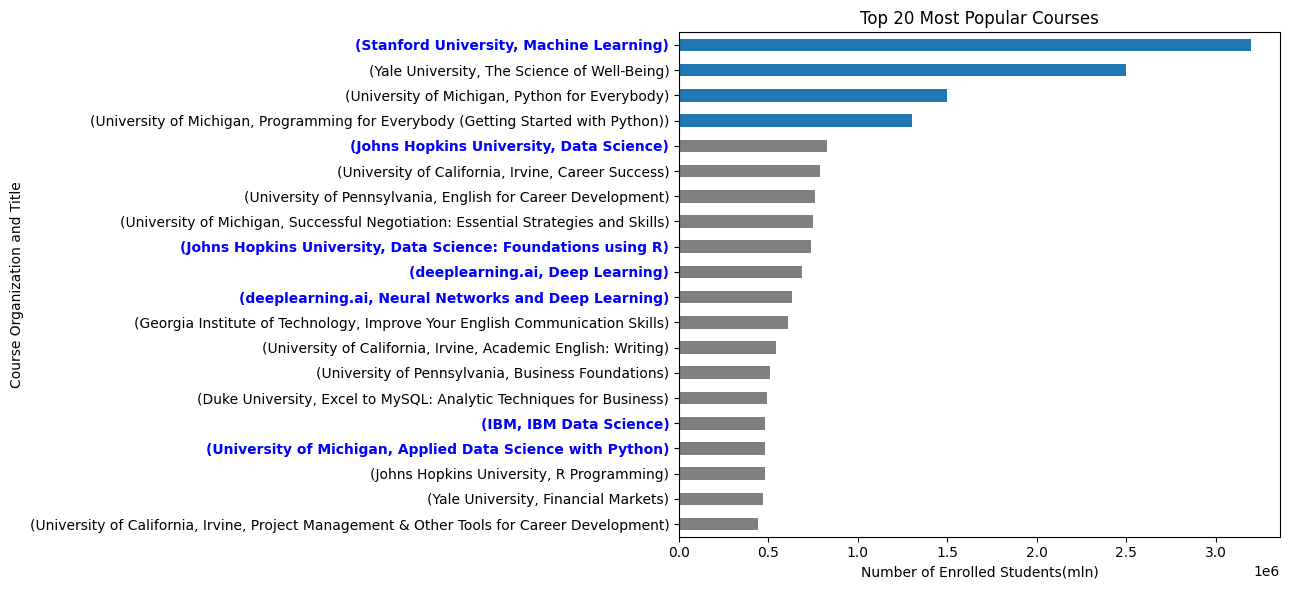

In [148]:
top_20_courses = (
    courses.groupby(["course_organization", "course_title"])
    .course_students_enrolled.sum()
    .sort_values(ascending=False)[:20]
)

# Reverse the order for horizontal bar chart
top_20_courses = top_20_courses.iloc[::-1]

# Plot the bar chart
ax = top_20_courses.plot(kind="barh", figsize=(13, 6))
plt.ylabel("Course Organization and Title")
plt.xlabel("Number of Enrolled Students(mln)")
plt.title("Top 20 Most Popular Courses")

# Highlight specific labels
highlight_keywords = ["Machine Learning", "Data Science", "Deep Learning"]
for label in ax.get_yticklabels():
    for keyword in highlight_keywords:
        if keyword in label.get_text():
            label.set_color("blue")
            label.set_fontweight("bold")

for i in range(len(ax.patches) - 4):
    ax.patches[i].set_facecolor("grey")

plt.tight_layout()
plt.show()

All **Data Science** related courses are marked <span style="color: blue; font-weight: bold;">blue</span>.

- A lot of Data Science courses.
- There are 4 leading courses, and 2 of them are related to Programming

### Top 20 organizations

In [87]:
# Top 20 organizations by courses count
top_org = (
    courses["course_organization"]
    .value_counts()
    .sort_values(ascending=False)
    .head(20)
    .index
)
top_org_courses = courses[courses.course_organization.isin(top_org)]

# Data for plot 1
courses_count_by_difficulty = top_org_courses.pivot_table(
    index="course_organization",
    columns="course_difficulty",
    aggfunc="size",
    fill_value=0,
).reindex(columns=["Mixed", "Beginner", "Intermediate", "Advanced"])

courses_count_by_difficulty["total"] = courses_count_by_difficulty.sum(axis=1)
courses_count_by_difficulty = courses_count_by_difficulty.sort_values(
    by=["total", "Mixed"], ascending=True
)  # Ordering by total

# Top 20 organizations by enrolled students count
top_org_by_enrolled = (
    courses.groupby("course_organization")
    .course_students_enrolled.sum()
    .sort_values(ascending=False)[:20]
    .index
)
top_enrolled_courses = courses[courses.course_organization.isin(top_org_by_enrolled)]

# Data for plot 2
courses_by_enrolled = top_enrolled_courses.pivot_table(
    index="course_organization",
    columns="course_difficulty",
    values="course_students_enrolled",
    aggfunc="sum",
    fill_value=0,
).reindex(  # Columns order
    columns=[
        "Mixed",
        "Beginner",
        "Intermediate",
        "Advanced",
    ]
)

courses_by_enrolled["total"] = courses_by_enrolled.sum(axis=1)  # Finding total
courses_by_enrolled = courses_by_enrolled.sort_values(  # Ordering by total
    by=["total", "Mixed"], ascending=True
)

Portion of Top 20 Organizations in Overall

In [ ]:
top_org_perc_enrolled = (
    top_enrolled_courses.course_students_enrolled.sum()
    / courses.groupby("course_organization").course_students_enrolled.sum().sum()
)
top_org_perc_courses = top_enrolled_courses.size / courses.size

print(
    f"""From Enrolled Overall: {top_org_perc_enrolled:.2f}%\nFrom Courses Count Overall: {top_org_perc_courses:.2f}%"""
)

From Enrolled Overall: 0.69%
From Courses Count Overall: 0.47%


In [90]:
colors = {
    "Mixed": "#1f77b4",  # Dark Blue
    "Beginner": "#aec7e8",  # Light Blue
    "Intermediate": "#98df8a",  # Light Green
    "Advanced": "#d62728",  # Dark Red
}


fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=(
        "Top 20 Organizations by Number of Courses",
        "Top 20 Organizations by Popularity",
    ),
    horizontal_spacing=0.25,  # Avoiding overlap
)

# Adding plot 1
for difficulty in colors.keys():
    fig.add_trace(
        go.Bar(
            y=courses_count_by_difficulty.index,
            x=courses_count_by_difficulty[difficulty],
            name=difficulty,
            orientation="h",
            marker_color=colors[difficulty],
            legendgroup=difficulty,  # Grouping both labels
        ),
        col=1,
        row=1,
    )

# Adding plot 2
for difficulty in colors.keys():
    fig.add_trace(
        go.Bar(
            y=courses_by_enrolled.index,
            x=courses_by_enrolled[difficulty],
            name=difficulty,
            orientation="h",
            marker_color=colors[difficulty],
            legendgroup=difficulty,
        ),
        col=2,
        row=1,
    )

# Update layout for both subplots
fig.update_layout(
    title_text=f"Top 20 Organizations: Courses and Popularity (Portion from Overall: {top_orc_perc:.2f})",
    barmode="stack",
    height=600,
    width=1400,
    xaxis=dict(title="Number of Courses"),
    xaxis2=dict(title="Number of Students Enrolled (mln)"),
    xaxis_title="Number of Courses",
    xaxis2_title="Number of Students Enrolled(mln)",
    legend=dict(title="Difficulty", orientation="h", yanchor="middle", y=-0.2),
)


fig.show()

- _University of Pennsylvania_ has the most courses, but _University of Michigan_ is the most popular organization.
- The most popular difficulty level is **mixed**. Although the most number of courses are in **beginner** level.
- Very few enrolled for _advanced_.

Is there a correlation between course rating and enrolled number?

In [142]:
courses.corr()

,course_rating,course_students_enrolled
course_rating,1.00000,0.07109
course_students_enrolled,0.07109,1.00000


 - Surprisingly no correlation between course rating and enrolled number

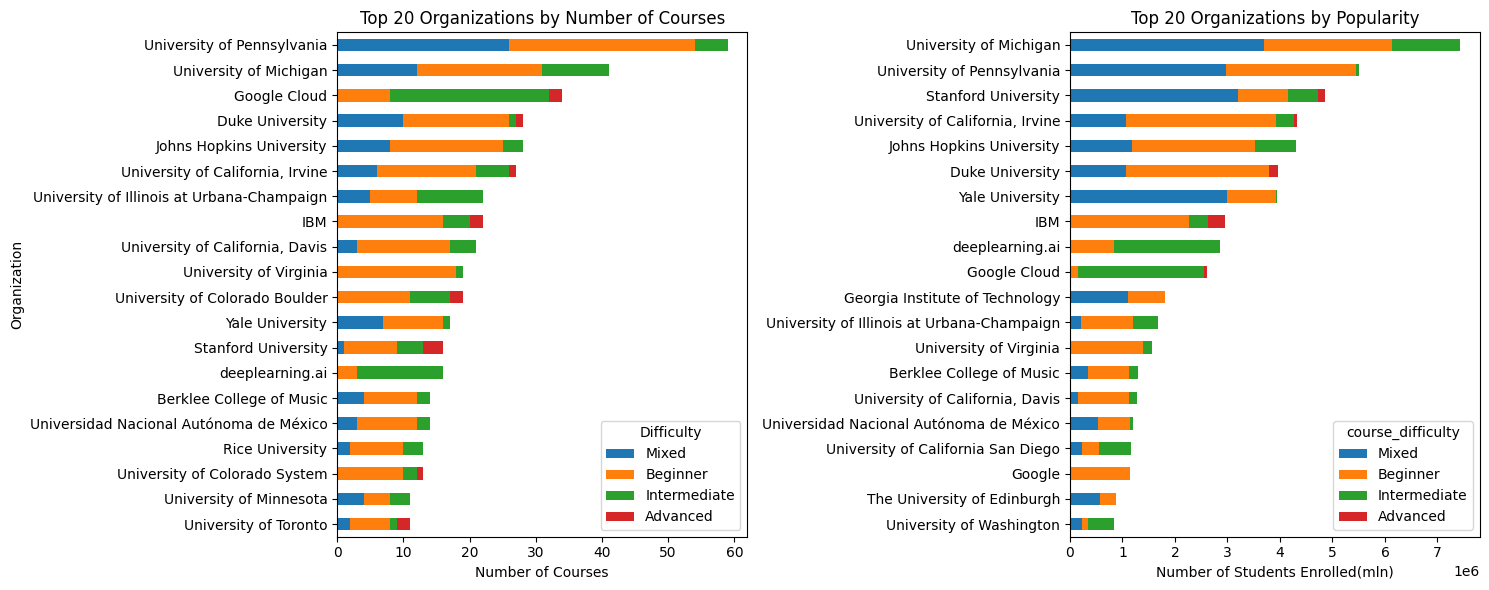

In [127]:
# Same plot with matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

courses_count_by_difficulty.loc[:, courses_count_by_difficulty.columns != "total"].plot(
    kind="barh", stacked=True, ax=axes[0]
)
axes[0].set_title("Top 20 Organizations by Number of Courses")
axes[0].set_ylabel("Organization")
axes[0].set_xlabel("Number of Courses")
axes[0].legend(title="Difficulty", loc="lower right")

# Plot 2: Top organizations by enrolled count


courses_by_enrolled.loc[:, courses_by_enrolled.columns != "total"].plot(
    kind="barh",
    stacked=True,
    ax=axes[1],
)
axes[1].set_title("Top 20 Organizations by Popularity")
axes[1].set_xlabel("Number of Students Enrolled(mln)")
axes[1].set_ylabel("")

fig.tight_layout()

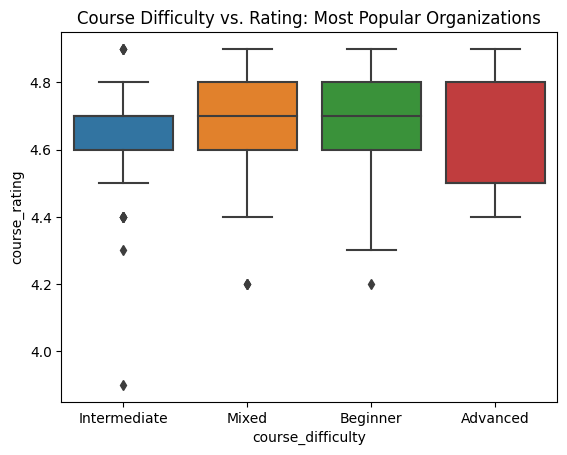

course_difficulty
Advanced        4.61
Beginner        4.69
Intermediate    4.65
Mixed           4.71
Name: course_rating, dtype: float64

In [ ]:
sns.boxplot(x="course_difficulty", y="course_rating", data=top_enrolled_courses)
plt.title("Course Difficulty vs. Rating: Most Popular Organizations")
plt.show()
top_enrolled_courses.groupby("course_difficulty").course_rating.mean().round(2)

- Not much difference

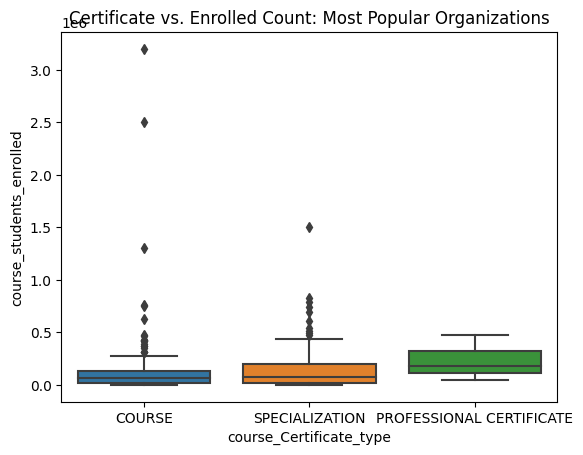

course_Certificate_type
COURSE                      35163300
PROFESSIONAL CERTIFICATE     1757000
SPECIALIZATION              18694900
Name: course_students_enrolled, dtype: int64

In [ ]:
sns.boxplot(
    x="course_Certificate_type", y="course_students_enrolled", data=top_enrolled_courses
)
plt.title("Certificate vs. Enrolled Count: Most Popular Organizations")
plt.show()
top_enrolled_courses.groupby(
    "course_Certificate_type"
).course_students_enrolled.sum().round()

- The average number of enrolled is higher for _Professional Certificate_, but in overall count the _Course_ is leading.

Which organizations offer the most courses for beginners?

In [ ]:
beginner_courses = (
    courses.groupby(["course_organization", "course_difficulty"])
    .size()
    .reset_index(name="course_count")
)
beginner_courses = beginner_courses[beginner_courses["course_difficulty"] == "Beginner"]
beginner_courses.loc[beginner_courses["course_count"].idxmax()]

course_organization    University of Pennsylvania
course_difficulty                        Beginner
course_count                                   28
Name: 243, dtype: object

Are certain organizations focusing more on advanced-level courses?

In [ ]:
course_counts = (
    courses.groupby(["course_organization", "course_difficulty"])
    .size()
    .reset_index(name="course_count")
)
course_pivot = course_counts.pivot_table(
    index="course_organization",
    columns="course_difficulty",
    values="course_count",
    aggfunc="sum",
    fill_value=0,
)
course_pivot["advanced_vs_other"] = (
    course_pivot["Advanced"] / course_pivot.sum(axis=1)
).round(2)
course_pivot_sorted = course_pivot.sort_values(by="advanced_vs_other", ascending=False)
course_pivot_sorted[:5]

course_difficulty,Advanced,Beginner,Intermediate,Mixed,advanced_vs_other
course_organization,,,,,
Autodesk,2,0,2,0,0.50
Erasmus University Rotterdam,1,3,0,1,0.20
Stanford University,3,8,4,1,0.19
University of Toronto,2,6,1,2,0.18
National Research University Higher School of Economics,1,5,1,0,0.14


### Suggestions for Improvement

- Additional Features: Include factors such as course price, reviews, or instructor experience for deeper insights.
- Segmentation: Segment courses based on ratings or enrollment into low, medium, and high to find patterns.
- Text Analysis: Analyze course_title for trends in keywords indicating popular topics.

# Conclusion
The analysis revealed several key insights about Coursera courses. 
- Most courses cater to beginners, and the majority have high ratings, typically between 4.7 and 4.8. 
- Mixed-difficulty courses are the most popular, while professional certificates attract the highest average enrollment. However, "Advanced" courses and "Specialization" certificates tend to have lower ratings. 
- Notably, there is no correlation between course ratings and enrollment numbers. 
- Universities like the University of Pennsylvania offer the most courses, but the University of Michigan leads in popularity.

Further improvements, such as incorporating additional features (e.g., course price or reviews), segmenting courses by ratings or enrollment, and conducting text analysis on course titles, can enhance the depth and accuracy of future analyses.